# 해상도, fov 다른 이미지 정규화

In [1]:
import os
import re
import glob
import math
import cv2

from itertools import chain

In [2]:
tan = math.tan
atan = math.atan
sqrt = math.sqrt
rad = math.radians
deg = math.degrees

# fov normalize

## goal
- 이미지 화각이 요구 화각보다 크면 요구 화각 영역 밖을 크로핑 처리
- 이미지 화각이 요구 화각보다 작으면 모자란 영역을 패딩 처리

## term
- to = 이미지 원본 길이
- tn = 새로운 이미지 길이 
- fo = 이미지 원본 fov
- fn = 새로운 이미지 fov

## formula
- tan, atan, 삼각형 활용

In [25]:
def get_length_diff(image_length, fov_image, fov_after, is_rad=True):
    to, fo, fa = image_length, fov_image, fov_after
    if not is_rad:
        fo, fa = rad(fo), rad(fa)
    far = to / tan(fo/2)
    tn_minus_to = far * (tan(fa/2)-tan(fo/2))
    return tn_minus_to

def is_portrait(img):
    h, w = img.shape[:2]
    return h > w

In [74]:
def conversion(img, fov_img_l, fov_img_s, fov_new_l, fov_new_s, is_rad=True):
    ### everyone 평균 디바이스(S6 기준) fov
    if not is_rad:
        fov_new_l = deg(0.9494591)  # 54'
        fov_new_s = deg(0.73579728) # 42'
    
    ### vc-gathering app에서 horizontal fov는 값을 제대로 출력하나 
    ### vertical은 잘못 계산되어 들어가있으므로 역산하여 올바른 값 계산
    fov_img_s = 2 * np.arctan(np.tan(fov_img_l / 2) * 720 / 1280)
    
    is_port = is_portrait(img)
    if is_port:   # long, short
        fov_img_l, fov_img_s = fov_img_s, fov_img_l     
        fov_new_l, fov_new_s = fov_new_s, fov_new_l    

    pad_color = [0, 0, 0]
    img_h, img_w = img.shape[:2]
    l_diff = get_length_diff(img_h, fov_img_l, fov_new_l, is_rad)
    s_diff = get_length_diff(img_w, fov_img_s, fov_new_s, is_rad)
    
    if l_diff > 0 or s_diff > 0:
        l_pad, s_pad = max(0, int(l_diff/2)), max(0, int(s_diff/2))
        img = cv2.copyMakeBorder(img, l_pad, l_pad, s_pad, s_pad, cv2.BORDER_CONSTANT, value=pad_color)
    if l_diff < 0:
        l_margin = -min(0, int(l_diff/2))
        img = img[l_margin:-l_margin, :, :]
    if s_diff < 0:
        s_margin = -min(0, int(s_diff/2))
        img = img[:, s_margin:-s_margin, :]
    
    # cv2.resize [col, row] order!!!
    resize_to = (480, 640)  if is_port else (640, 480)
    img = cv2.resize(img, resize_to, interpolation=cv2.INTER_AREA)
    
    return img

In [77]:
def convert_fov(img, fov_img_h, fov_img_w, fov_new_h, fov_new_w, is_rad=True):
    # fov_img_w = 2 * np.arctan(np.tan(fov_img_h / 2) * 720 / 1280)
    fov_img_w = 2 * np.arctan(np.tan(fov_img_h / 2) * 720 / 1280)
    
    is_port = is_portrait(img)
    if not is_port:   # TODO: 핸드폰 정위에 따라 API가 알아서 변경해줬는지 체크
        fov_img_h, fov_img_w = fov_img_w, fov_img_h
        fov_new_h, fov_new_w = fov_new_w, fov_new_h

    pad_color = [0, 0, 0]
    img_h, img_w = img.shape[:2]
    h_diff = get_length_diff(img_h, fov_img_h, fov_new_h, is_rad)
    w_diff = get_length_diff(img_w, fov_img_w, fov_new_w, is_rad)
    
    if h_diff > 0 or w_diff > 0:
        h_pad, w_pad = max(0, int(h_diff/2)), max(0, int(w_diff/2))
        img = cv2.copyMakeBorder(img, h_pad, h_pad, w_pad, w_pad, cv2.BORDER_CONSTANT, value=pad_color)

    if h_diff < 0:
        h_margin = -min(0, int(h_diff/2))
        img = img[h_margin:-h_margin, :, :]
    if w_diff < 0:
        w_margin = -min(0, int(w_diff/2))
        img = img[:, w_margin:-w_margin, :]
        
    if is_port:
        resize_to = (480, 640)
    else:
        resize_to = (640, 480)

    img = cv2.resize(img, resize_to, interpolation=cv2.INTER_AREA)
    return img

# sample to image

In [23]:
def load_modules():
    import sys
    sys.path.append("../../../")
    %run ../../../ac/common/images.py
    %run ../../../ac/visualizer/plotter.py
load_modules()

In [60]:
# def video_to_frames(video_path, save_base_path):
#     filename = os.path.basename(video_path)
#     filename = os.path.splitext(filename)[0]
#     save_dir_path = "{}/{}".format(save_base_path, filename)
    
#     if not os.path.exists(save_dir_path):
#         os.makedirs(save_dir_path)
    
#     video_capture = cv2.VideoCapture(video_path)
#     success, image = video_capture.read()

#     count = 0
#     while success:
#         save_path = "{}/frame-{:05d}.jpg".format(save_dir_path, count)
#         cv2.imwrite(save_path, image)
#         success, image = video_capture.read()
#         count += 1
#         if success is not True:
#             print('>>> {} exit frame [{}]'.format(save_dir_path, count))
    
#     return count

In [61]:
# def grep_recur(base_path, pattern="*.mp4"):
#     sub_greps = [os.path.join(base_path, name) for name in os.listdir(base_path)]
#     dir_paths = [sub_path for sub_path in sub_greps if os.path.isdir(sub_path)]
#     greps = glob.glob("{}/{}".format(base_path, pattern))
#     sub_greps = list(chain(*[grep_recur(dp, pattern) for dp in dir_paths]))

#     return greps + sub_greps

In [62]:
# vid_path = "/home/chy/dev-bench/auto-catch/notes/research/camera-image-conversion/samples/"
# save_path = "/home/chy/dev-bench/auto-catch/notes/research/camera-image-conversion/samples/img/"
# vid_paths = grep_recur(vid_path)

In [63]:
# for vid_path in vid_paths:
#     video_to_frames(vid_path, save_path)

>>> /home/chy/dev-bench/auto-catch/notes/research/camera-image-conversion/samples/img//1280-720-2 exit frame [1630]


# demo

In [46]:
def get_img(name):
    path = "/home/chy/dev-bench/auto-catch/notes/research/camera-image-conversion/samples/{}.jpg".format(name)
    img = cv2.imread(path)
    print(img.shape)
    return img

(720, 1280, 3)


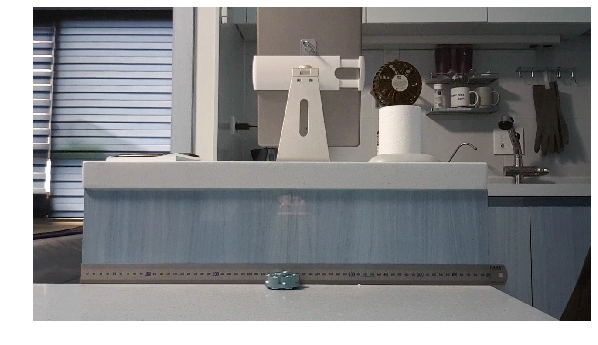

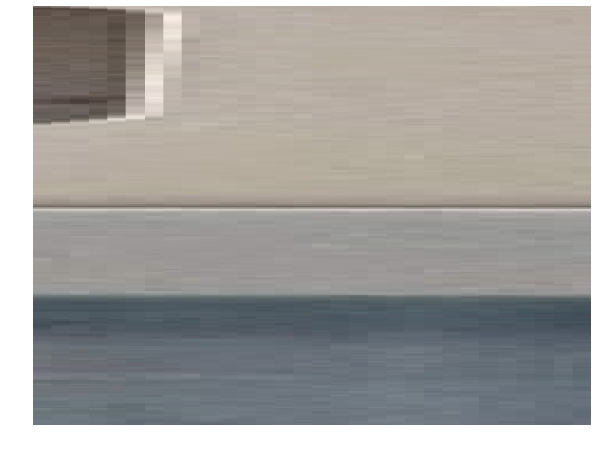

In [58]:
h1280x720 = get_img("h1280x720")
show_image(h1280x720)
h_new = convert_fov(h1280x720, 40, 80, 60, 90, False)
show_image(h_new)

# 격자 데모

### 아이폰 계열 fov 분포
#### - everyone 기기별 1.2도 정도 편차
#### - 스펙과 실측은 2도 정도 차이 있음
![](./samples/iphone-device-fov.png)

<br>

### 아래 이미지는 계산 과정 스크린샷하여서 1280 아님

### 640-45cell-187mm-far-173mm-54.4deg
- 셀 칸을 세면 45개인데 45칸은 191mm 이지만 비뚤어진 것 보정하여 187mm
- 아이폰6s 640 비디오 녹화시 (45칸 - 187mm - 측정 거리 173mm - 메타데이터 기준 fov 54.4')  
![640](./samples/640-45cell-187mm-far-173mm-54.4deg.png)

<br>

### 1280-48cell-198mm-far-143mm-67.56deg
- 계속 비뚤게 찍혀서 평행으로 맞추었을 때 부족한 칸을 2칸 추가하여 보정함
- 아이폰8 1270 비디오 녹화시(gathering app) (48칸 - 198mm - 측정 거리 143mm - 메타 기준 fov 67.56')  
![1280](./samples/1280-48cell-198mm-far-143mm-67.56deg.png)

<br>

### convert_fov는 fov의 비율로 crop 하거나 padding 방식으로 동작


In [20]:
### everyone (iphone 6s)에서 동영상 녹화 시 격자로 실측한 fov 
h = 187/2
far = 173
actual_fov = deg(atan(h/far)) * 2
print("메타 정보 fov: {}, 격자 실측 fov: {} ".format(actual_fov, 54.4))

### 1280x720 vc-one에서 수집한 아이폰8 기준
h = 198/2
far = 143
actual_fov = deg(atan(h/far)) * 2
print("메타 정보 fov: {}, 격자 실측 fov: {} ".format(actual_fov, 67.56))

메타 정보 fov: 56.77911153295542, 격자 실측 fov: 54.4 
메타 정보 fov: 69.39030706246794, 격자 실측 fov: 67.56 


# 예시

### 1280 비디오 이미지 (장축 기준)
### 원래 fov 67.5'에서 56.8'로 변환함.
### 변경 후 실측 58.448'

실제 잘렸을 때 fov: 58.448838380401824, 요청한 fov 56.77911153295542, 자르기전 fov 67.56432911741693


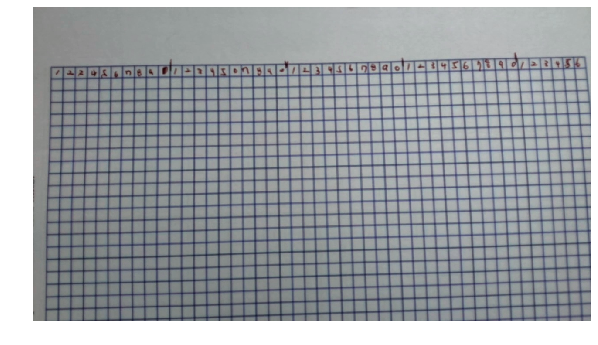

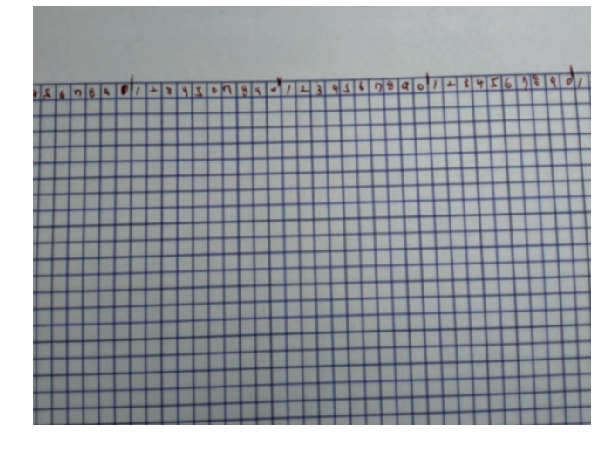

In [97]:
##  fov_new_h = 0.9494591 # 54
##  fov_new_w = 0.73579728 # 42

# 0.9599310885968813 55'
# 0.7444503338203187 42.65

image_file_name = "frame-00355.jpg"
path = "/home/chy/dev-bench/auto-catch/notes/research/camera-image-conversion/samples/{}".format(image_file_name)
img = cv2.imread(path)
show_image(img)
new_img = convert_fov(img, rad(69.39030706246794), 0.73579728, 0.9494591, 0.73579728, False)  
show_image(new_img)

### 변환 후 이미지에서 19 cell == 161mm / 2 == 80
actual_fov = deg(atan(80 / 143)) * 2
print("실제 잘렸을 때 fov: {}, 요청한 fov {}, 자르기전 fov {}".format(
    actual_fov, 56.77911153295542, deg(1.17922)))

In [ ]:
##  fov_new_h = 0.9494591 # 54
##  fov_new_w = 0.73579728 # 42

In [15]:
rad(55)

0.9599310885968813

In [13]:
fov_h, fov_w = 0.9494591, 0.73579728
hdw_r = tan(fov_h/2) / tan(fov_w/2)
k = 2*atan( tan(rad(55)/2) / hdw_r)
print(hdw_r, k)


1.333333314751377 0.7444503338203187
